In [11]:
# 3 Layer CNN Model w/o Bidirectional with 23 features in pre processing
# Paper -> Deep Convolutional Bidirectional LSTM Based Transportation Mode Recognition

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/user1-all-h5/_hand.h5
/kaggle/input/user1-all-h5/_hips.h5
/kaggle/input/user1-all-h5/_torso.h5
/kaggle/input/user1-all-h5/_bag.h5
/kaggle/input/torsomotionremovednan/torso.h5
/kaggle/input/torsomotionremovednan/tm3.txt
/kaggle/input/torsomotionremovednan/torso-motion.h5
/kaggle/input/torsomotionremovednan/tm2.txt
/kaggle/input/torsomotionremovednan/tm1.txt
/kaggle/input/shl-dataset/Torso_Motion3.txt
/kaggle/input/shl-dataset/Label.txt
/kaggle/input/shl-dataset/Torso_Motion.txt
/kaggle/input/shl-dataset/Label2.txt
/kaggle/input/shl-dataset/Label3.txt
/kaggle/input/shl-dataset/Torso_Motion2.txt


In [2]:
import numpy as np
import h5py
def read_motion():
    motions =[]
    torso_motion = ["/kaggle/input/torsomotionremovednan/tm1.txt","/kaggle/input/torsomotionremovednan/tm2.txt","/kaggle/input/torsomotionremovednan/tm3.txt"]
    labels = ["/kaggle/input/shl-dataset/Label.txt","/kaggle/input/shl-dataset/Label2.txt","/kaggle/input/shl-dataset/Label3.txt"]
    motions = torso_motion
    data = np.array([]) 
    for i, file in enumerate(motions):
        np_motion = np.loadtxt(file)
#         np_motion = downsize(np_motion)
        print(np_motion.shape)
        start = np_motion[0,0].astype(np.int64)
        end = np_motion[-1,0].astype(np.int64)
        label = labels[i]
        np_label = np.loadtxt(label)
        start_index = np.where(np_label == start)[0][0]
        end_index = np.where(np_label == end)[0][0] 
        np_label = find_labels(np_label,start_index,end_index)
        folder_id = np.full(np_label.shape, i) # put folder_id in the last column
        concatenate = np.concatenate((np_motion,np_label,folder_id),axis=1)
        if i == 0:
            data = concatenate
        else:
            data = np.concatenate((data,concatenate))

#     print(data.shape)
#     print(data[:5,:])
#     for i in range(1, 20):
#         data[:,i:i+1] = np.square(data[:,i:i+1])
#     i = 1
#     print(data[:5,:])
#     while(i<20):
#         if(i != 10):
#             data[:,i:i+1] = data[:,i:i+1]+data[:,i+1:i+2]+data[:,i+2:i+3]
#             data[:,i:i+1] = np.sqrt(data[:,i:i+1])
#             i=i+3
#         else:
#             data[:,i:i+1] = data[:,i:i+1]+data[:,i+1:i+2]+data[:,i+2:i+3]+data[:,i+3:i+4]
#             data[:,i:i+1] = np.sqrt(data[:,i:i+1])
#             i=i+4
#     data = np.delete(data, [2,3,5,6,8,9,11,12,13,15,16,18,19], 1)
#     print(data[:5,:])
    return data

# def downsize(data):# data is numpy array
#     downsample_size = 10
#     data = data[::downsample_size,:]
#     return data

def find_labels(labels,start_index, end_index):
#     interval = 10
    interval=1
    label_col_index = 1 # the 2 column of Label.txt
    data = labels[start_index: end_index+1:interval, label_col_index].reshape(-1,1) # need to be the shape like (n,1), so that it can be concatenate later
    return data

def save_data(data,file_name): # save the data in h5 format
    f = h5py.File(file_name,'w')
    for key in data:
        print(key)
        f.create_dataset(key,data = data[key])       
    f.close()

def segment(data, window_size): # data is numpy array
    n = len(data)
    X = []
    y = []
    start = 0
    end = 0
    while start + window_size - 1 < n:
        end = start + window_size-1
        if data[start][-2]!=0 and data[start][-2] == data[end][-2] and data[start][-1] == data[end][-1] : # if the frame contains the same activity and from the same object
            X.append(data[start:(end+1),1:-2])
            y_label = data[start][-2]
            if y_label == 8:
                y.append(0) # change label 8 to 0
            else:
                y.append(data[start][-2])
            start += window_size//2 # 50% overlap
        else: # if the frame contains different activities or from different objects, find the next start point
            while start + window_size-1 < n:
                if data[start][-2] == 0 or data[start][-2] != data[start+1][-2]:
                    break
                start += 1
            start += 1
    print(np.asarray(X).shape, np.asarray(y).shape)
    return {'inputs' : np.asarray(X), 'labels': np.asarray(y,dtype=int)}
    print('Done.')  


if __name__ == "__main__":
    file = "torso.h5" 
    data = read_motion()
    segment_data = segment(data,500)
    save_data(segment_data, file)

(4644801, 23)
(3898101, 23)
(3396501, 23)
(24260, 500, 22) (24260,)
inputs
labels


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Reshape, Conv2D, Dense, Flatten, Dropout, SimpleRNN, GRU, LSTM, GlobalMaxPooling1D,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import MaxPooling2D, Bidirectional, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.vis_utils import plot_model

In [13]:
class models():
    def __init__(self, path):
        self.path = path
        
        
    def read_h5(self):
        f = h5py.File(path, 'r')
        X = f.get('inputs')
        y = f.get('labels') 
        
        X = np.array(X)
        y = np.array(y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
        print(self.x_train.shape,self.y_train.shape)
    def draw(self):
        f1 = plt.figure(1)
        plt.title('Loss')
        plt.plot(self.r.history['loss'], label = 'loss')
        plt.plot(self.r.history['val_loss'], label = 'val_loss')
        plt.legend()
        f1.show()
        
        f2 = plt.figure(2)
        plt.plot(self.r.history['acc'], label = 'accuracy')
        plt.plot(self.r.history['val_acc'], label = 'val_accuracy')
        plt.legend()
        f2.show()    
    def cnn_model(self):
        K = len(set(self.y_train))
#         print(K)
        
        print(self.x_train.shape,self.y_train.shape)
#         Input_shape should be a 4dim vectors as stated in the keras doc:
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test,-1)
        print(self.x_train.shape,self.y_train.shape)
        
        i = Input(shape=self.x_train[0].shape)
        print(self.x_train[0].shape)
        
        x = Conv2D(filters=8, kernel_size=(6, 6), activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.005))(i)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(filters=16, kernel_size=(3, 3), activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.005))(i)
        x = AveragePooling2D((2, 2))(x)
        x = Conv2D(filters=32, kernel_size=(3, 3), activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.005))(i)
#       x = MaxPooling2D((2, 2))(x)
        x = Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.005))(i)
        #x = MaxPooling2D((2, 2)         
        #x = Bidirectional(LSTM(32))(x)
        x = Flatten()(x)
        x = Dense(512, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        #layers.Dense(32, activation='relu')
        x = Dense(8, activation='softmax')(x)
        #layers.Dense(32, activation='relu')
        """
        x = Conv2D(16, (3,3), strides = 2, activation = 'relu',padding='same',kernel_regularizer=regularizers.l2(0.0005))(i)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)    
        x = Dropout(0.2)(x)
        x = Dense(128,activation = 'relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        x = Dense(K, activation = 'softmax')(x)       
        """
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(learning_rate=0.0005),loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
        
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 50,batch_size = 64)
        print(self.model.summary())
        return self.r
    def cnn_model_2(self):
        
        K = len(set(self.y_train))
#         print(K)
        
        print(self.x_train.shape,self.y_train.shape)
#         Input_shape should be a 4dim vectors as stated in the keras doc:
        self.x_train = np.expand_dims(self.x_train, -1)
        self.x_test = np.expand_dims(self.x_test,-1)
        print(self.x_train.shape,self.y_train.shape)
        
        i = Input(shape=self.x_train[0].shape)
        print(self.x_train[0].shape)
        x = Conv2D(8, (8, 8), activation = 'relu')(i)
        #x = BatchNormali0zation()(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        #x = Dropout(0.2)(x)
        #x = Flatten()(x)    
        #x = Dropout(0.2)(x)
        x = Conv2D(16, (4, 4), activation = 'relu')(i)
        #x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
        #x = Dropout(0.2)(x)
        #x = Flatten()(x)  
        #x = Dropout(0.2)(x)
        x = Conv2D(24, (3, 3), activation = 'relu')(i)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(48, (3, 3), activation = 'relu')(i)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(96, (3, 3), activation = 'relu')(i)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(192, (3, 3), activation = 'relu')(i)
        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Conv2D(256, (2, 2), activation = 'relu')(i)
        x = MaxPooling2D(pool_size=(2,2))(x)
#        x = Conv2D(512, (2, 2), activation = 'relu')(i)
#        x = MaxPooling2D(pool_size=(2,2))(x)
        x = Flatten()(x)
#        x = Dense(1024, activation = 'relu')(x)
        x = Dense(256, activation = 'relu')(x)
        x = Dense(96, activation = 'relu')(x)
        x = Dense(48, activation = 'relu')(x)
        x = Dense(24, activation = 'relu')(x)
        #x = Lambda(ReshapeLayer)
#         shape = self.x_train.shape
#         reshape = Reshape((shape[1],shape[2]*shape[3]))(x)
        #x = Bidirectional(LSTM(64, return_sequences=False))(x)
        #x = Bidirectional(LSTM(64))(x)
        x = Dense(8, activation = 'softmax')(x)
        
        self.model = Model(i,x)
        self.model.compile(optimizer = Adam(learning_rate=0.0002),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 200, batch_size = 16 )
        print(self.model.summary())
        return self.r
    
    def rnn_model(self):
        K = len(set(self.y_train))
        i = Input(shape = self.x_train[0].shape)
        x = LSTM(128, return_sequences=True)(i)
        #x = LSTM(128, return_sequences=True)(i)
        x = Dense(128,activation = 'relu')(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(K,activation = 'softmax')(x)
        self.model = Model(i,x)      
        self.model.compile(optimizer = Adam(lr=0.005),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
        self.r = self.model.fit(self.x_train, self.y_train, validation_data = (self.x_test, self.y_test), epochs = 200, batch_size = 64)
        #self.r = model.fit(X, y, validation_split = 0.2, epochs = 10, batch_size = 32 )
        print(self.model.summary())
        return self.r
    
    def ann_model(self):
        x = Sequential()
        x.add(Dense(units=6, input_dim=10, activation='relu', kernel_initializer='he_uniform'))
        x.add(Dense(units=4, activation='relu', kernel_initializer='he_uniform'))
        x.add(Dense(units=2, input_dim=10, activation='relu', kernel_initializer='he_uniform'))
        x.add(Dense(units=1, input_dim=10, activation='sigmoid', kernel_initializer='glorot_uniform'))
        x.compile(optimizer="adam",loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
        model_history=x.fit(self.x_train, self.y_train, validation_split=0.33, batch_size=128, nb_epoch=10)
        print(model_history.summary())
        return self.model_history
        
    def con_matrix(self):
        K = len(set(self.y_train))
        self.y_pred = self.model.predict(self.x_test).argmax(axis=1)
        cm = confusion_matrix(self.y_test,self.y_pred)
        self.plot_confusion_matrix(cm,list(range(K)))
    
    def plot_confusion_matrix(self, cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
            print("Normalized confusion matrix")
        else:
            print("Confusion matrix, without normalization")
        print(cm)
        f3 = plt.figure(3)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
        fmt = '.2f' if normalize else 'd' 
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('predicted label')
            f3.show()


2022-12-14 17:26:03.023147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:26:03.024316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:26:03.025778: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:26:03.027116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 17:26:03.028625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

(9716, 500, 22) (9716,)
(9716, 500, 22) (9716,)
(9716, 500, 22, 1) (9716,)
(500, 22, 1)
Train on 9716 samples, validate on 2430 samples
Epoch 1/200
9716/9716 [==============================] - 35s 4ms/sample - loss: 19.0791 - acc: 0.4810 - val_loss: 2.0326 - val_acc: 0.7395
Epoch 2/200
9716/9716 [==============================] - 35s 4ms/sample - loss: 1.4792 - acc: 0.7329 - val_loss: 0.8847 - val_acc: 0.6872
Epoch 3/200
9716/9716 [==============================] - 35s 4ms/sample - loss: 0.7084 - acc: 0.8097 - val_loss: 0.5711 - val_acc: 0.8436
Epoch 4/200
9716/9716 [==============================] - 35s 4ms/sample - loss: 0.5077 - acc: 0.8367 - val_loss: 0.4048 - val_acc: 0.8658
Epoch 5/200
9716/9716 [==============================] - 35s 4ms/sample - loss: 0.3930 - acc: 0.8705 - val_loss: 0.5273 - val_acc: 0.8350
Epoch 6/200
9716/9716 [==============================] - 35s 4ms/sample - loss: 0.3719 - acc: 0.8807 - val_loss: 0.6505 - val_acc: 0.7872
Epoch 7/200
9716/9716 [============

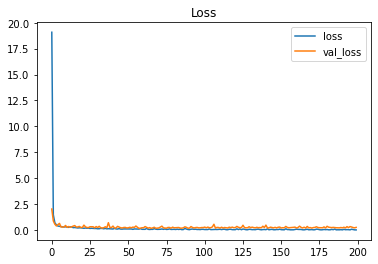

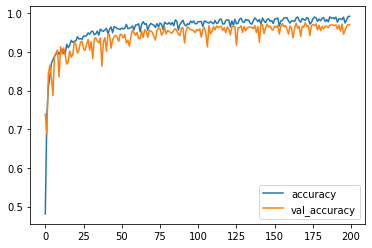

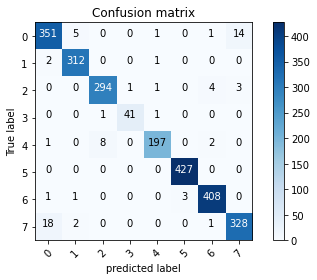

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess= tf.Session(config=config)

def new_model(self):
    trainX = self.x_train
    trainy = self.y_train

#     self.model = Sequential()
#     self.model.add(tf.keras.Input(shape=(trainX.shape[1], trainX.shape[2])))
#     self.model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'))
#     self.model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'))
#     self.model.add(tf.keras.layers.Reshape((-1,32*61)))
#     self.model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')))
#     self.model.add(tf.keras.layers.Dense(64, activation='relu'))
#     self.model.add(tf.keras.layers.Dropout(0.2))
#     self.model.add(tf.keras.layers.Dense(64, activation='relu'))
#     self.model.add(tf.keras.layers.Dropout(0.2))
#     self.model.add(tf.keras.layers.Dense(trainy.shape[1], activation='softmax'))
#     #model.output_shape

#     self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#                   loss=tf.keras.losses.CategoricalCrossentropy(),
#                   metrics=['accuracy'])

#     self.model.summary()
    x = Sequential()
    x.add(Input(shape=(trainX.shape[1], trainX.shape[2])))
    x.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    x.add(Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'))
    x.add(Reshape((-1,32*61)))
    x.add(Bidirectional(LSTM(16, activation='relu')))
    x.add(Dense(64, activation='relu'))
    x.add(Dropout(0.2))
    x.add(Dense(64, activation='relu'))
    x.add(Dropout(0.2))
    x.add(Dense(trainy.shape[1], activation='softmax'))
    #model.output_shape

    x.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])

    x.summary()


#####################
model_name = "cnn" 
path='/kaggle/input/user1-all-h5/_bag.h5'
motion = models(path)
motion.read_h5()
model=motion.cnn_model_2()
motion.draw()
motion.con_matrix()
# model=motion.rnn_model()
# motion.draw()
# motion.con_matrix()

In [ ]:
data[:10, :]

